## **Librerías**

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import r2_score,median_absolute_error
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, learning_curve, ShuffleSplit

## **Lectura información**

In [ ]:
#Descargar datasets desde github
!git clone https://github.com/andres-soto-h/monografia-udea-eacd.git

Cloning into 'monografia-udea-eacd'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [ ]:
#Lectura del dataset transformado
df_propiedades=pd.read_csv('/content/monografia-udea-eacd/df_prop_clean_12082021.csv', delimiter=';', encoding='latin1')
df_propiedades.shape

(2485, 184)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd '/content/drive/My Drive/Colab Notebooks/Seminario/DATASETS'
# # !ls
# df_propiedades=pd.read_csv('df_prop_clean_12082021.csv', delimiter=';', encoding='latin1') 
# print(df_propiedades.shape)

In [ ]:
df_propiedades.rename(columns={"municipio":"ubicacion"}, inplace=True)
mask_union = df_propiedades['ubicacion']!='la uniÃ³n'
df_propiedades = df_propiedades[mask_union]
df_propiedades['estrato'] = df_propiedades['estrato'].replace('Campestre', '0')
df_propiedades['log_precio'] = np.log1p(df_propiedades['precio'])

## **Modelamiento**

### **Conjunto de Datos**

In [ ]:
data_model=df_propiedades.copy()
#columnas_quitar=['tipo','url','titulo','descripcion','caractint','caractext','caractsec']
columnas_quitar=['url','titulo','descripcion','caractint','caractext','caractsec','otros_datos']
data_model.drop(columnas_quitar, axis=1, inplace=True)
data_model['estrato'] = data_model['estrato'].astype(int)
data_model.shape

(2481, 178)

In [ ]:
X_model = data_model.drop(['precio','log_precio'], axis=1)
y_model = data_model['precio']
y_trans = data_model['log_precio']

**OneHotEncoder**

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
data_aux = pd.DataFrame(enc.fit_transform(X_model[['tipo','tipo_propiedad','ubicacion','antiguedad']]).toarray(), columns= enc.get_feature_names(['tipo','tipo_propiedad','ubicacion','antiguedad']))
data_aux['fila'] = range(0, X_model.shape[0])
data_aux.head()

X_model.drop(['tipo','tipo_propiedad','antiguedad'],axis=1, inplace=True)
X_model['fila'] = range(0, X_model.shape[0])
print(X_model.shape, data_aux.shape)
X_model = pd.merge(data_aux,X_model, on = 'fila', how='inner')
X_model.drop(['fila'], axis=1, inplace=True)
X_model.shape

(2481, 174) (2481, 22)


(2481, 194)

In [ ]:
var_ubicacion=X_model['ubicacion']
X_model.drop(['ubicacion'], axis=1, inplace=True)

**División train/test**

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_model,y_model, train_size=0.8, stratify = X_model['ubicacion'],  random_state = 42)

# ubicacion_train = X_train['ubicacion']
# ubicacion_test = X_test['ubicacion']

# X_train.drop('ubicacion',axis=1, inplace=True)
# X_test.drop('ubicacion',axis=1, inplace=True)

# # Variable Objetivo Transformada
# y_train_t = np.log1p(y_train)
# y_test_t = np.log1p(y_test)

In [ ]:
# X_train.shape

## **Curva de Aprendizaje** 

**Función:**

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

**Curva de Aprendizaje**

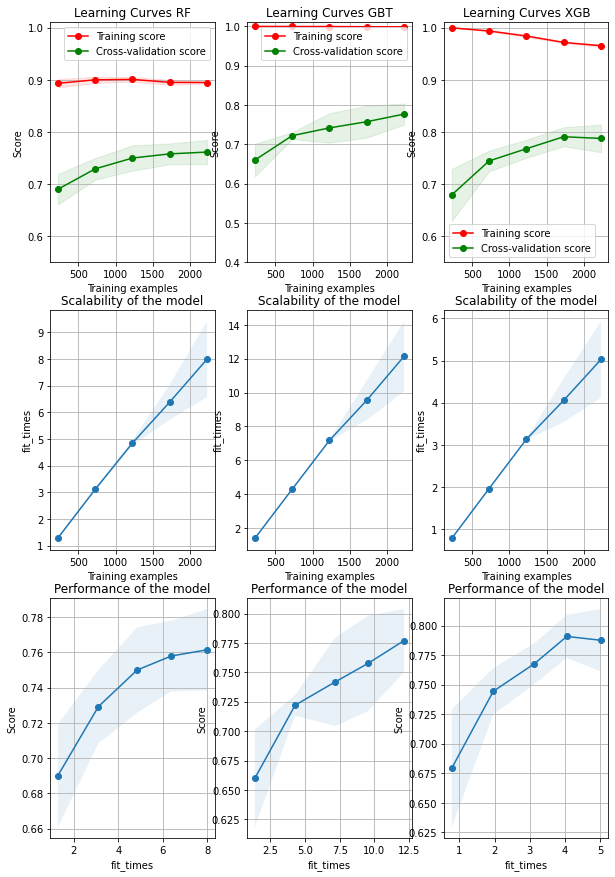

In [ ]:
# X, y = X_train, y_train
X,y = X_model, y_model

fig, axes = plt.subplots(3, 3, figsize=(10, 15))
title = "Learning Curves RF"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42).split(X, var_ubicacion)

# estimator = GaussianNB()
estimator = Pipeline(steps = [('scaler', StandardScaler()), ('rf',RandomForestRegressor(max_depth=9, min_samples_leaf=4, min_samples_split=4
                                                                                        ,n_estimators=150, random_state=42))])

plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.55, 1.01),cv=cv, n_jobs=4)

title = r"Learning Curves GBT"
# SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42).split(X, var_ubicacion)

estimator = Pipeline(steps = [('scaler', StandardScaler()), ('gbt', GradientBoostingRegressor(max_depth=9, min_samples_leaf=3, min_samples_split=4,
 n_estimators=150, random_state=42))])

plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.4, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves XGB"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42).split(X, var_ubicacion)

# estimator = GaussianNB()
estimator = Pipeline(steps = [('scaler', StandardScaler()), ('xgb',xgb.XGBRegressor(max_depth=6, n_jobs=-1
                                                                                ,objective='reg:squarederror', reg_alpha=0.01))])

plot_learning_curve(estimator, title, X, y, axes=axes[:, 2], ylim=(0.55, 1.01),cv=cv, n_jobs=4)


plt.show()